***Import Needed Libraries***

In [1]:
#Import libraries etc

import pandas as pd
import re
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
import statsmodels.api as sm
import warnings # supress warnings
warnings.filterwarnings('ignore')

***#Function to read in passed URL, read url into dataframe, fill in missing year with year return dataframe***

In [2]:
def comb_df(url_nm,yr):
    result = pd.DataFrame()
    result = pd.read_html(url)[0]    
    result['Drafted (tm/rnd/yr)'] = result['Drafted (tm/rnd/yr)'].fillna(yr) 
    result.update(result[['40yd','Vertical','Bench','Broad Jump','3Cone','Shuttle']].fillna(0))
    return result

url = 'https://www.pro-football-reference.com/draft/2022-combine.htm'
df_2022 = comb_df(url,2022)
df_2022.head()

,Player,Pos,School,College,Ht,Wt,40yd,Vertical,Bench,Broad Jump,3Cone,Shuttle,Drafted (tm/rnd/yr)
0,Cal Adomitis,LS,Pittsburgh,College Stats,6-2,235,4.97,29.5,18,107,7.53,4.62,2022
1,Austin Allen,TE,Nebraska,College Stats,6-8,253,4.83,34.0,0,121,7.00,4.26,2022
2,Chase Allen,TE,Iowa St.,College Stats,6-6,251,0,33.5,0,117,7.03,4.43,2022
3,Christopher Allen,EDGE,Alabama,College Stats,6-4,241,0,0,0,0,0,0,2022
4,Tyler Allgeier,RB,BYU,College Stats,5-11,224,4.60,33.0,0,120,0,0,Atlanta Falcons / 5th / 151st pick / 2022


**Create Dataframe to hold all rows from all years**

In [3]:
df_combine = pd.DataFrame() 
df_combine = df_combine.append(df_2022)
df_combine = df_combine[df_combine['Pos'] != 'Pos']

**Import 2021 combine results.** 
***Note: 2021 Combine was cancelled due to pandemic. Results of players pro days was used***

In [4]:
# 2020 NFL Combine Results
url = 'https://www.pro-football-reference.com/draft/2019-combine.htm'
df_2021 = comb_df(url,2021)
df_2021 = df_2021[df_2021['Pos'] != 'Pos']
df_combine = df_combine.append(df_2021)

**Import 2020 combine results.**

In [5]:
# 2020 NFL Combine Results
url = 'https://www.pro-football-reference.com/draft/2019-combine.htm'
df_2020 = comb_df(url,2020)
df_2020 = df_2020[df_2020['Pos'] != 'Pos']
df_combine = df_combine.append(df_2020)

***Import 2019 combine results***

In [6]:
# 2019 NFL Combine Results
url = 'https://www.pro-football-reference.com/draft/2019-combine.htm'
df_2019 = comb_df(url,2019)
df_2019 = df_2019[df_2019['Pos'] != 'Pos']
df_combine = df_combine.append(df_2019)

***Import 2018 combine results and append to combine dataframe***

In [7]:
# 2018 NFL Combine Results
url = 'https://www.pro-football-reference.com/draft/2018-combine.htm'
df_2018 = comb_df(url,2018)
df_2018 = df_2018[df_2018['Pos'] != 'Pos']
df_combine = df_combine.append(df_2018)


***Import 2017 combine results and append to combine dataframe***

In [8]:
# 2017 NFL Combine Results
url = 'https://www.pro-football-reference.com/draft/2017-combine.htm'
df_2017 = comb_df(url,2017)
df_2017 = df_2017[df_2017['Pos'] != 'Pos']
df_combine = df_combine.append(df_2017)

***Import 2016 combine results and append to combine dataframe***

In [9]:
# 2016 NFL Combine Results
url = 'https://www.pro-football-reference.com/draft/2016-combine.htm'
df_2016 = comb_df(url,2016)
df_2016 = df_2016[df_2016['Pos'] != 'Pos']
df_combine = df_combine.append(df_2016)

**Import 2015 combine results and append to combine dataframe**

In [10]:
# 2015 NFL Combine Results
url = 'https://www.pro-football-reference.com/draft/2015-combine.htm'
df_2015 = comb_df(url,2015)
df_2015 = df_2015[df_2015['Pos'] != 'Pos']
df_combine = df_combine.append(df_2015)

**Encode school name as a number using Ordinal encoder function**

In [11]:
enc = OrdinalEncoder()
enc.fit(df_combine[['School']])
df_combine[['School']] = enc.transform(df_combine[['School']])

**Split column 'Drafted (tm/rnd/yr)' into 4 columns - Team, Round, Pick and Year**

In [12]:
df_combine[['Team', 'Round','Pick', 'Year']] = df_combine['Drafted (tm/rnd/yr)'].str.split('/', expand=True)
df_combine = df_combine.drop(columns=['Drafted (tm/rnd/yr)'],)

**Drop suffix on round number leaving just round player drafted in.  0 = not drafted.**

In [13]:

char_to_replace = {'nd ' : '', 'st ':'','rd ':'','th ':'', 'pick ':''}
for key, value in char_to_replace.items():
    df_combine['Pick'] = df_combine['Pick'].str.replace(key,value)  
for key, value in char_to_replace.items():
    df_combine['Round'] = df_combine['Round'].str.replace(key,value)
df_combine.update(df_combine[['Team']].fillna('None'))   
df_combine.update(df_combine[['Round','Pick','Year']].fillna(0))

**Remove any title rows interspersed in dataframe**

In [14]:
df_combine = df_combine[df_combine['Pos'] != 'Pos']

**Convert positions from character to numeric**

In [15]:
conditions = [
    (df_combine['Pos'] == 'S'),
    (df_combine['Pos'] == 'OT'),
    (df_combine['Pos'] == 'LB'),
    (df_combine['Pos'] == 'EDGE'),
    (df_combine['Pos'] == 'DL'),
    (df_combine['Pos'] == 'RB'),
    (df_combine['Pos'] == 'WR'),
    (df_combine['Pos'] == 'CB'),
    (df_combine['Pos'] == 'P'),
    (df_combine['Pos'] == 'OL'),
    (df_combine['Pos'] == 'TE'),
    (df_combine['Pos'] == 'QB'),
    (df_combine['Pos'] == 'K'),
    (df_combine['Pos'] == 'LS'),
    (df_combine['Pos'] == 'FB'),
    (df_combine['Pos'] == 'C'),
    (df_combine['Pos'] == 'DE'),
    (df_combine['Pos'] == 'DT'),
    (df_combine['Pos'] == 'ILB'),
    (df_combine['Pos'] == 'OLB'),
    (df_combine['Pos'] == 'OG'),
    (df_combine['Pos'] == 'DB')
]
choices = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22]
df_combine['Pos'] = np.select(conditions,choices, default=0)

**Split Height into 2 separate columns 1 for feet 1 for inches so 6-2 becomes 2 separate columns 6 2**

In [16]:
df_combine[['Feet', 'Inches']] = df_combine['Ht'].str.split('-', expand=True)
df_combine["Feet"] = pd.to_numeric(df_combine["Feet"])
df_combine["Inches"] = pd.to_numeric(df_combine["Inches"])

**Multiply feet by 12 to convert feet to inches. Add feet converted to inches to inches to get height in inches**

In [17]:
df_combine["Feet"] = df_combine["Feet"] * 12
df_combine['Ht'] = df_combine["Feet"] + df_combine["Inches"]
df_combine = df_combine.drop(columns=['Feet','Inches'])

**Convert all columns to numeric and fill in any missing values with 0**

In [18]:
df_combine["Pos"] = pd.to_numeric(df_combine["Pos"])
df_combine["Wt"] = pd.to_numeric(df_combine["Wt"])
df_combine["40yd"] = pd.to_numeric(df_combine["40yd"])
df_combine["Vertical"] = pd.to_numeric(df_combine["Vertical"])
df_combine["Bench"] = pd.to_numeric(df_combine["Bench"])
df_combine["Broad Jump"] = pd.to_numeric(df_combine["Broad Jump"])
df_combine["3Cone"] = pd.to_numeric(df_combine["3Cone"])
df_combine["Shuttle"] = pd.to_numeric(df_combine["Shuttle"])
df_combine["Round"] = pd.to_numeric(df_combine["Round"])
df_combine["Pick"] = pd.to_numeric(df_combine["Pick"])
df_combine["Year"] = pd.to_numeric(df_combine["Year"])
df_combine = df_combine.fillna(0)

**populate drafted column with 0 where Round = 0 otherwise populate it with 1 if it has a value greater than 0.**
**drop columns

In [19]:
df_combine['Drafted'] = np.where(df_combine['Round']!= 0, 1, 0)
df_combine1 = df_combine
df_combine1 = df_combine1.drop(columns=['Player','College','Team','Round','Year','Pick'])

**Describe dataframe of 2015 thru 2021 draft**

In [20]:
#describe dataframe of 2015 thru 2021 draft
df_combine1.describe()

,Pos,School,Ht,Wt,40yd,Vertical,Bench,Broad Jump,3Cone,Shuttle,Drafted
count,2649.000000,2649.000000,2649.000000,2649.000000,2649.000000,2649.000000,2649.000000,2649.000000,2649.000000,2649.000000,2649.000000
mean,8.661759,122.234051,74.011325,242.215176,3.967074,25.765383,13.357116,90.276708,4.153749,2.645878,0.654964
std,5.793166,71.201225,2.597761,44.764318,1.788668,14.103241,10.481356,49.342903,3.615704,2.170804,0.475470
min,1.000000,0.000000,66.000000,156.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,62.000000,72.000000,205.000000,4.440000,25.500000,0.000000,98.000000,0.000000,0.000000,0.000000
50%,7.000000,117.000000,74.000000,231.000000,4.600000,31.500000,16.000000,115.000000,6.870000,4.150000,1.000000
75%,12.000000,191.000000,76.000000,280.000000,4.890000,35.000000,22.000000,121.000000,7.240000,4.410000,1.000000
max,22.000000,240.000000,82.000000,384.000000,5.850000,45.000000,42.000000,147.000000,8.720000,5.380000,1.000000


**Create Correlation Matrix of fields** 

In [21]:
corrM = df_combine1.corr()
corrM = corrM.sort_values(by ='Pos',ascending=True)
print(corrM)

                 Pos    School        Ht        Wt      40yd  Vertical  \
Vertical   -0.048125  0.027576 -0.087853 -0.142870  0.445453  1.000000   
Broad Jump -0.044456  0.044915 -0.063005 -0.097968  0.452272  0.864853   
School      0.013833  1.000000  0.029464  0.014640  0.058620  0.027576   
Drafted     0.027125  0.004439  0.049638  0.088088  0.070211  0.104162   
Bench       0.051863  0.052467  0.103652  0.346929  0.146233  0.139631   
Shuttle     0.097662  0.058394  0.176978  0.212929  0.387124  0.523709   
3Cone       0.098213  0.038713  0.166011  0.196460  0.370964  0.489905   
40yd        0.133501  0.058620  0.060678  0.110646  1.000000  0.445453   
Ht          0.165974  0.029464  1.000000  0.705394  0.060678 -0.087853   
Wt          0.250303  0.014640  0.705394  1.000000  0.110646 -0.142870   
Pos         1.000000  0.013833  0.165974  0.250303  0.133501 -0.048125   

               Bench  Broad Jump     3Cone   Shuttle   Drafted  
Vertical    0.139631    0.864853  0.489905  0.

**Create Correlation Heat Map**

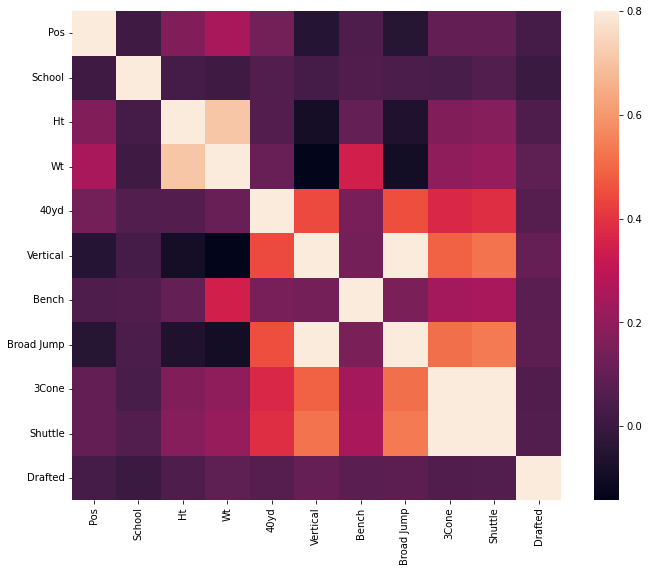

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

corrmat = df_combine1.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat,vmax=.8,  square=True);

**Calculate Covariance values**

In [23]:
covar1 = df_combine1.cov()
covar1 = covar1.sort_values(by ='Drafted',ascending=False)
print(covar1)

                  Pos       School         Ht           Wt       40yd  \
Broad Jump -12.707730   157.798127  -8.076020  -216.391890  39.916660   
Wt          64.910422    46.662232  82.028151  2003.844165   8.859232   
Vertical    -3.931917    27.690507  -3.218641   -90.196854  11.237002   
Bench        3.149160    39.155434   2.822238   162.775847   2.741525   
Drafted      0.074716     0.150273   0.061311     1.874876   0.059711   
School       5.705706  5069.614384   5.449765    46.662232   7.465568   
3Cone        2.057209     9.966377   1.559293    31.797970   2.399133   
Pos         33.560777     5.705706   2.497790    64.910422   1.383342   
Ht           2.497790     5.449765   6.748361    82.028151   0.281944   
40yd         1.383342     7.465568   0.281944     8.859232   3.199333   
Shuttle      1.228182     9.025569   0.998019    20.691325   1.503144   

              Vertical       Bench   Broad Jump      3Cone    Shuttle  \
Broad Jump  601.846667   80.072974  2434.722120  9

**Create Boxplots of variables with top covariances**

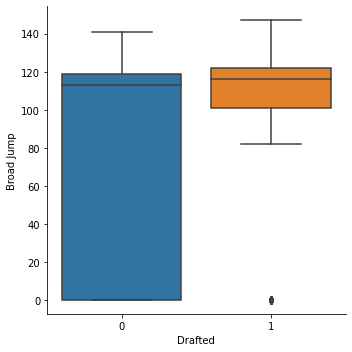

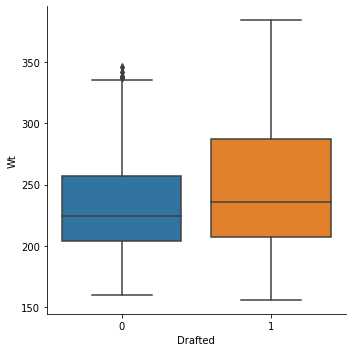

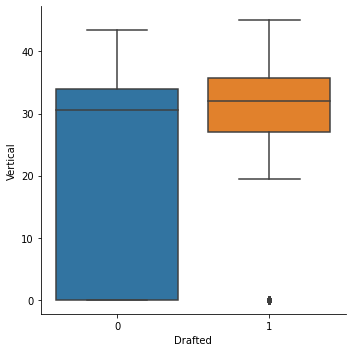

In [24]:
sns.catplot(x="Drafted", y="Broad Jump",  kind="box",data=df_combine1)
sns.catplot(x="Drafted", y="Wt",  kind="box",data=df_combine1)
sns.catplot(x="Drafted", y="Vertical",  kind="box",data=df_combine1);

**Create skewness and curtosis plots**

Skewness: -0.652328
Kurtosis: -1.575658


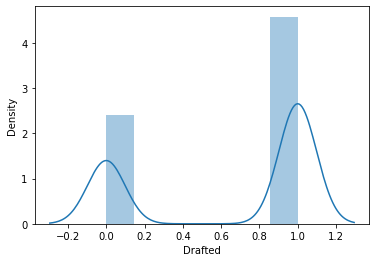

In [25]:
df_combine1.to_csv('drafted.csv')
sns.distplot(df_combine1['Drafted']);
print("Skewness: %f" % df_combine1['Drafted'].skew())
print("Kurtosis: %f" % df_combine1['Drafted'].kurt());

**Histogram of Drafted vs Undrafted**

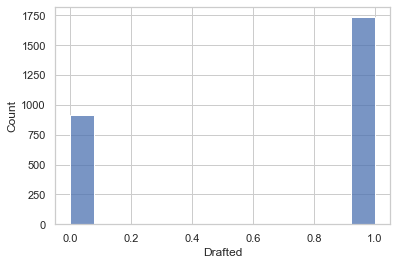

In [26]:
sns.set_theme(style="whitegrid")
sns.histplot(df_combine1['Drafted']);

**Create feature and targets**

In [27]:
feature_cols  = ['Pos','School','Ht','Wt','40yd','Vertical','Bench','Broad Jump','3Cone','Shuttle']
target = df_combine1['Drafted']
X = df_combine1[feature_cols]
y = target

**Split into training and test**

In [304]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)

**scale train and test**

In [305]:
from sklearn.preprocessing import StandardScaler

sc_x = StandardScaler()
xtrain = sc_x.fit_transform(X_train)
xtest = sc_x.transform(X_test) 


**Perform Logistic Regression to predict whether player will be drafted or not**

In [306]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(xtrain,y_train)
y_pred=logreg.predict(xtest)

**Confusion Matrix Calculation**

In [307]:
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[ 13, 229],
       [ 22, 399]], dtype=int64)

In [308]:
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,13,229,242
1,22,399,421
All,35,628,663


**Create confusion matrix for predicted**

In [309]:
%matplotlib inline

Text(0.5, 257.44, 'Predicted label')

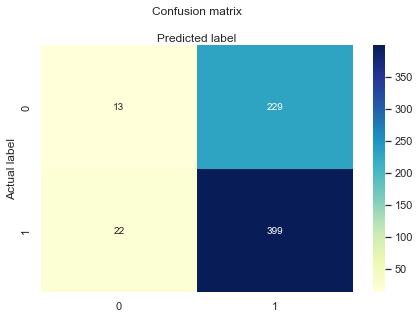

In [310]:

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

**Print Accuracy, Precision and Recall**

In [311]:
# metrics.precision_score(y_test, y_pred)
print(metrics.classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.37      0.05      0.09       242
           1       0.64      0.95      0.76       421

    accuracy                           0.62       663
   macro avg       0.50      0.50      0.43       663
weighted avg       0.54      0.62      0.52       663



**Calculate and plot AUC**

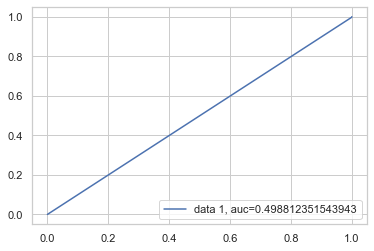

In [312]:
#plot AUC
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

**Use Neural Net to calculate whether player is drafted or not**

In [313]:
# Importing Keras libraries
from keras.models import Sequential
from keras.layers import Dense

classifier = Sequential()

# Adding input layer 8 inputs
classifier.add(Dense(8, activation = 'relu'))

# Adding hidden layer 1st hidden layer rule of thumb take # of inputs add outputs and divide by 2
# 8 inputs + 2 outputs (1,0) /2 = 5
# more hidden layers longer processing time
classifier.add(Dense(5, activation = 'relu'))

classifier.add(Dense(2, activation = 'relu'))


# Adding output layer Binary so only one sigmoid used to classify data into 2 types (from logistic regression)
classifier.add(Dense(1, activation = 'sigmoid'))

# Compiling ANN Algorithm
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Fitting ANN Algorithm to Training set
classifier.fit(xtrain, y_train, batch_size = 10, epochs = 150)

Epoch 1/150
199/199 [==============================] - 1s 1ms/step - loss: 0.6885 - accuracy: 0.5770
Epoch 2/150
199/199 [==============================] - 0s 1ms/step - loss: 0.6571 - accuracy: 0.6596
Epoch 3/150
199/199 [==============================] - 0s 1ms/step - loss: 0.6407 - accuracy: 0.6591
Epoch 4/150
199/199 [==============================] - 0s 1ms/step - loss: 0.6358 - accuracy: 0.6591
Epoch 5/150
199/199 [==============================] - 0s 1ms/step - loss: 0.6335 - accuracy: 0.6586
Epoch 6/150
199/199 [==============================] - 0s 1ms/step - loss: 0.6329 - accuracy: 0.6581
Epoch 7/150
199/199 [==============================] - 0s 1ms/step - loss: 0.6310 - accuracy: 0.6576
Epoch 8/150
199/199 [==============================] - 0s 1ms/step - loss: 0.6294 - accuracy: 0.6596
Epoch 9/150
199/199 [==============================] - 0s 969us/step - loss: 0.6284 - accuracy: 0.6586
Epoch 10/150
199/199 [==============================] - 0s 1ms/step - loss: 0.6268 - accu

**Predict drafted**

In [314]:
# # Predicting y_test using X_test 
# y_pred = classifier.predict(xtest)
_, accuracy = classifier.evaluate(xtest, y_test)
print('Accuracy: %.2f' % (accuracy*100))

21/21 [==============================] - 0s 1ms/step - loss: 0.6632 - accuracy: 0.6440
Accuracy: 64.40


**Predict using K Nearest Neighbors**

In [315]:
# predict round for drafted players
df_round_df = df_combine.loc[df_combine['Round'] > 0]
feature_cols  = ['Pos','School','Ht','Wt','40yd','Vertical','Bench','Broad Jump','3Cone']
target = df_round_df['Round']
X = df_round_df[feature_cols]
y = target


**Train test split**

In [316]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20)

**Feature Scaling**

In [317]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [318]:
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline

**Look at the error rate for different k values**

In [319]:
rmse_val = [] #to store rmse values for different k
for K in range(20):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(X_train, y_train)  #fit the model
    pred=model.predict(X_test) #make prediction on test set
    error = sqrt(mean_squared_error(y_test,pred)) #calculate rmse
    rmse_val.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)

RMSE value for k=  1 is: 1.9708863649596378
RMSE value for k=  2 is: 1.8852561500881218
RMSE value for k=  3 is: 1.937859296040971
RMSE value for k=  4 is: 1.9878151220718623
RMSE value for k=  5 is: 1.995688995428393
RMSE value for k=  6 is: 2.0194939495972397
RMSE value for k=  7 is: 2.0110289277179576
RMSE value for k=  8 is: 1.9882694278993165
RMSE value for k=  9 is: 1.957516387173176
RMSE value for k=  10 is: 1.9352525189594065
RMSE value for k=  11 is: 1.93492146650604
RMSE value for k=  12 is: 1.9329230180495665
RMSE value for k=  13 is: 1.9345677153933947
RMSE value for k=  14 is: 1.947422170052245
RMSE value for k=  15 is: 1.9408299279557069
RMSE value for k=  16 is: 1.9375670089102315
RMSE value for k=  17 is: 1.9352428038575917
RMSE value for k=  18 is: 1.937659047967414
RMSE value for k=  19 is: 1.942305062758043
RMSE value for k=  20 is: 1.9359356448005314


**Plot RMSE against K values**

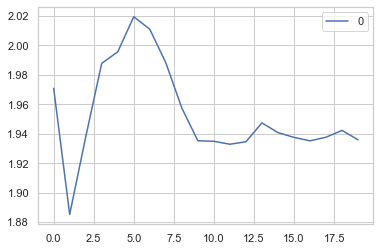

In [320]:
curve = pd.DataFrame(rmse_val) #elbow curve 
curve.plot();

**Use GridsearchCV to find best value**

In [321]:
from sklearn.model_selection import GridSearchCV
params = {'n_neighbors':[2,3,4,5,6,7,8,9]}

knn = neighbors.KNeighborsRegressor()

model = GridSearchCV(knn, params, cv=5)
model.fit(X_train,y_train)
model.best_params_

{'n_neighbors': 9}

In [322]:
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=9)

In [323]:
accuracy = knn.score(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

Accuracy: 27.17


**Linear Regression**

In [324]:
feature_cols  = ['Pos','School','Ht','Wt','40yd','Vertical','Bench','Broad Jump','3Cone','Shuttle']
target = df_combine1['Drafted']
X = df_combine1[feature_cols]
y = target

In [325]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)

In [326]:
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
xtrain = sc_x.fit_transform(X_train)
xtest = sc_x.transform(X_test)

**Create model using Random Forest**

In [327]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train,y_train);

**Calculate Accuracy of Random Forest**

In [334]:
y_pred=clf.predict(X_test)
Accuracy = metrics.accuracy_score(y_test, y_pred)
print('Accuracy: %.2f' % (Accuracy*100))

Accuracy: 80.39


In [329]:
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

Mean squared error: 0.20
Coefficient of determination: 0.15


In [330]:
import seaborn as sn

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)


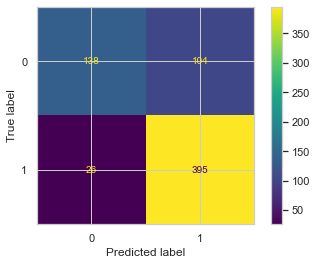

In [331]:
from sklearn.metrics import ConfusionMatrixDisplay
## Display the visualization of the Confusion Matrix.
ConfusionMatrixDisplay.from_predictions(
   y_test, y_pred);

**So it appears that Random Forest is the best method to use in this cse to predict whether a player will be drafted or not based on their NFL Scouting Combine Measurements.**